This notebook demonstrates how the [`spatialdata_xenium_explorer`](https://github.com/quentinblampey/spatialdata_xenium_explorer) library bridges Xenium Explorer and the [`spatialdata`](https://spatialdata.scverse.org/en/latest/) library.

Whether analyzing Xenium using `spatialdata` or in the Xenium Explorer, `spatialdata_xenium_explorer` ensures a fluid interchange of insights, allowing for easy navigation between analysis and visualization.

## Table of content

- Setup
- Image alignment
  - From the Xenium Explorer to `SpatialData`
  - From `SpatialData` to the Xenium Explorer
- Update the visualization
  - Update the cell categories/clusters
  - Update the segmentation
- Use the coordinates of a lasso selection in `SpatialData`
  - Selecting cells from a selection
  - Cropping a `SpatialData` object from a selection

# Setup

### Requirements
For this tutorial, you will need `python >= 3.9`.

Make sure to install `spatialdata_io >= 0.0.10` and `spatialdata_xenium_explorer >= 0.1.5`, i.e.:
```sh
pip install spatialdata-io
pip install spatialdata_xenium_explorer
```

In [1]:
import spatialdata
import spatialdata_io
import spatialdata_xenium_explorer

### Download tutorial data

This tutorial is based on a Xenium sample of human skin, which can be downloaded on this [10x Genomics webpage](https://www.10xgenomics.com/datasets/human-skin-preview-data-xenium-human-skin-gene-expression-panel-add-on-1-standard).
In particular, download the following directory/file:
- [Xenium Output Bundle (full)](https://cf.10xgenomics.com/samples/xenium/1.7.0/Xeniumranger_V1_hSkin_Melanoma_Add_on_FFPE/Xeniumranger_V1_hSkin_Melanoma_Add_on_FFPE_outs.zip) (unzip it into a directory)
- [Supplemental: Post-Xenium H&E image (OME-TIFF)](https://cf.10xgenomics.com/samples/xenium/1.7.0/Xeniumranger_V1_hSkin_Melanoma_Add_on_FFPE/Xeniumranger_V1_hSkin_Melanoma_Add_on_FFPE_he_image.ome.tif) (move it into the latter directory)

### Read the Xenium data

In [2]:
# directory containing the Xenium data you downloaded
data_path = "Xeniumranger_V1_hSkin_Melanoma_Add_on_FFPE_outs"

The Xenium data can be read by `spatialdata-io`:

In [3]:
sdata = spatialdata_io.xenium(data_path)

INFO     reading Xeniumranger_V1_hSkin_Melanoma_Add_on_FFPE_outs/cell_feature_matrix.h5                            


/Users/quentinblampey/dev/_external/spatialdata-io/src/spatialdata_io/readers/xenium.py:213: UserWarning: Converting `region_key: region` to categorical dtype.
  table = TableModel.parse(adata, region=specs["region"], region_key="region", instance_key=str(XeniumKeys.CELL_ID))


INFO     Feature key `feature_name`could be of type `pd.Categorical`. Consider casting it.                         
INFO     Feature key `feature_name`could be of type `pd.Categorical`. Consider casting it.                         
INFO     Feature key `feature_name`could be of type `pd.Categorical`. Consider casting it.                         
(1, 43287, 22209, 3)
INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           


# Image alignment

### Alignment from the Xenium Explorer to `SpatialData`

For this dataset, the H&E image has already been aligned, and `spatialdata` automatically uses the existing alignment file to load the H&E (see [here](https://spatialdata.scverse.org/projects/io/en/latest/generated/spatialdata_io.xenium_aligned_image.html) for more details). Yet, in practice, you may not already have alignment files for your own Xenium data. Thus, for the sake of this example, we show how to reconstruct this alignment using the Xenium Explorer interface, export it, and load it using the `spatialdata` package.

First, select "Add Image" under the "Images" panel:

<img src="assets/xenium/alignment_1.png" alt="image" width="800" height="auto">

Then, select the H&E image, i.e. the file called `Xeniumranger_V1_hSkin_Melanoma_Add_on_FFPE_he_image.ome.tif`:

<img src="assets/xenium/alignment_2.png" alt="image" width="800" height="auto">

As mentioned above, we assume that we don't already have an alignment file. Therefore, in the screenshot below, we click on "No, image is not aligned", and follow all the instructions until we align the image.

> If you want to use the existing alignment file instead, you can download it [here](https://cf.10xgenomics.com/samples/xenium/1.7.0/Xeniumranger_V1_hSkin_Melanoma_Add_on_FFPE/Xeniumranger_V1_hSkin_Melanoma_Add_on_FFPE_he_imagealignment.csv), and click on "Yes, use an existing alignment file" in the interface below.

<img src="assets/xenium/alignment_3.png" alt="image" width="800" height="auto">

Afterwards, the H&E image is aligned, and you can now superpose your cells:

<img src="assets/xenium/alignment_4.png" alt="image" width="800" height="auto">

#### Updating the `SpatialData` object

We can use the transformation from the Xenium Explorer to update the `SpatialData` object. For this, first export the transformation matrix as below:

<img src="assets/xenium/alignment_5.png" alt="image" width="800" height="auto">

Then, we will open the H&E tif image using `xenium_aligned_image`:

In [10]:
from spatialdata_io.readers.xenium import xenium_aligned_image
from pathlib import Path

In [12]:
# Path to the image alignment file
alignment_matrix_path = "Xeniumranger_V1_hSkin_Melanoma_Add_on_FFPE_he_imagealignment.csv"

# Path to the H&E image
he_path = Path(data_path) / "Xeniumranger_V1_hSkin_Melanoma_Add_on_FFPE_he_image.ome.tif"

image = xenium_aligned_image(he_path, alignment_matrix_path)

(1, 43287, 22209, 3)
INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           


In [14]:
# This is the name we will give to our image (can be changed)
image_name = "Xeniumranger_V1_hSkin_Melanoma_Add_on_FFPE_he_image"

sdata.add_image(image_name, image)

Now, we see that the image has been saved under `sdata['Xeniumranger_V1_hSkin_Melanoma_Add_on_FFPE_he_image']`:

In [15]:
sdata

SpatialData object with:
├── Images
│     ├── 'Xeniumranger_V1_hSkin_Melanoma_Add_on_FFPE_he_image': SpatialImage[cyx] (3, 43287, 22209)
│     ├── 'he_image': MultiscaleSpatialImage[cyx] (3, 43287, 22209), (3, 21643, 11104), (3, 10821, 5552), (3, 5410, 2776), (3, 2705, 1388)
│     ├── 'morphology_focus': MultiscaleSpatialImage[cyx] (1, 13725, 28467), (1, 6862, 14233), (1, 3431, 7116), (1, 1715, 3558), (1, 857, 1779)
│     └── 'morphology_mip': MultiscaleSpatialImage[cyx] (1, 13725, 28467), (1, 6862, 14233), (1, 3431, 7116), (1, 1715, 3558), (1, 857, 1779)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 10) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (87499, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (87499, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (87499, 2) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 87499 × 382
    obs: 'cell_id', 'transcript_counts', 'control_probe_

### Alignment from `SpatialData` to the Xenium Explorer

Now, we suppose you have already aligned your H&E image using `SpatialData`. Here, we detail how use the transformation inside the Xenium Explorer.

In [26]:
from spatialdata.transformations import get_transformation, Affine
import numpy as np

First, we get the transformation from the H&E image to the global coordinate system:

In [27]:
spatial_element = sdata["Xeniumranger_V1_hSkin_Melanoma_Add_on_FFPE_he_image"]

transformation = get_transformation(spatial_element, to_coordinate_system="global")

If it is an affine transformation, we can create a `.csv` file representing the transformation:

In [31]:
assert isinstance(
    transformation, Affine
), "The Xenium Explorer only supports Affine transformations"

alignment_matrix = transformation.to_affine_matrix(input_axes=["x", "y"], output_axes=["x", "y"])

np.savetxt("alignment_matrix.csv", alignment_matrix, delimiter=",")

Now, when adding a new image in the Xenium Explorer, select "Yes, use an existing alignment file", and upload the `alignment_matrix.csv` file that you just created.

<img src="assets/xenium/from_spatialdata.png" alt="image" width="800" height="auto">

# Update the visualization
### Update the cell categories/clusters

Here, we run some Leiden clustering with `scanpy`. Then, we will update the Xenium Explorer files to display the spot clusters.

More generally, you can add new cell categories, i.e. a column of `sdata.table.obs`, and the Xenium Explorer will show it after the instructions below.

> Note that we only display categorical columns. If a column from `sdata.table.obs` contains continuous numerical values (e.g., `3.13, 7.89, ...`), it will not be transformed into a categorical variable, and therefore not shown in the Xenium Explorer. In this case, we recommend using the [`spatiadata_plot`](https://spatialdata.scverse.org/projects/plot/en/latest/index.html) static plotting library.

In [ ]:
import scanpy as sc

sc.pp.normalize_total(sdata.table)
sc.pp.log1p(sdata.table)
sc.pp.pca(sdata.table)
sc.pp.neighbors(sdata.table)
sc.tl.leiden(sdata.table)

In [60]:
sc.tl.leiden(sdata.table)

Now, you can update the explorer with your new cluster assignment. You don't need to re-run the complete conversion; you can edit the `analysis.zarr.zip` file only, as below.

> Alternatively, you can use the `spatialdata_xenium_explorer` CLI instead of the API, as detailed [here](https://quentinblampey.github.io/spatialdata_xenium_explorer/cli/#update-obs).

In [61]:
spatialdata_xenium_explorer.write_cell_categories(data_path, sdata.table)

[INFO] (spatialdata_xenium_explorer.core.table) Writing 3 cell categories: region, lasso, leiden


To visualize these clusters, re-open the `experiment.xenium` file and select the new `"leiden"` cell group (under the "Cells" panel and in the "Cell groups" dropdown). See the examples above to see how it looks on the Xenium Explorer.

<img src="assets/xenium/leiden.png" alt="image" width="800" height="auto">

### Update the segmentation

If you performed your own segmentation, you may want to update the explorer with your new cells. You'll also need to update `sdata.table` to contain the transcript counts associated with your new cells. Such a new segmentation can, for instance, be obtained with [Sopa](https://github.com/gustaveroussy/sopa).

In [57]:
import spatialdata

In [7]:
# this is the key related to your new cell boundaries, i.e. sdata[shapes_key] is a pandas GeoDataFrame
shapes_key = "new_shapes"

# this is the name of the original image
image_key = "morphology_mip"

Now, update all the files related to your new cells:

> Note that `mode="-it"` signifies the creation of all files except the image and transcript file. Indeed, the two latter files don't need to be updated; they will remain the same.

In [ ]:
spatialdata_xenium_explorer.write(data_path, sdata, image_key=image_key, shapes_key=shapes_key, mode="-it")

# Use the coordinates of a lasso selection in `SpatialData`

On the Xenium Explorer, you can use the Lasso or Rectangular selection tools to select some regions of interest. Then, you'll be able to analyze back this region of interest using `spatialdata`.


### Selecting cells from a selection
After making a selection, click on "Download Cell Stats as CSV", as below. It will create a file called `"Selection_1_cells_stats.csv"`.

<img src="assets/xenium/lasso.png" alt="image" width="800" height="auto">

In [55]:
import pandas as pd
import numpy as np
import scanpy as sc

# add the path to the file that you downloaded, e.g. "Selection_1_cells_stats.csv"
df_selection = pd.read_csv("Selection_2_cells_stats.csv", skiprows=2)

# this line converts the Xenium spot ID into a spot index
spot_indices = df_selection["Cell ID"].map(spatialdata_xenium_explorer.utils.int_cell_id).values

sdata.table.obs["lasso"] = pd.Categorical(
    np.where(sdata.table.obs["cell_id"].isin(df_selection["Cell ID"].values), "selected", "not-selected")
)

Now, `sdata.table.obs["lasso"]` denotes which cells have been selected by the lasso tool (either "selected" or "not-selected").

We can then use `spatialdata_plot` to display the cells that were selected by the lasso tool. Make sure to install `spatialdata_plot >= 0.1.0`, e.g. via `pip install spatialdata_plot`. Now, we can render the shapes (i.e., the spots) and colour them based on the `"lasso"` column that was saved in `sdata.table.obs`:

In [33]:
import spatialdata_plot

/Users/quentinblampey/Library/Caches/pypoetry/virtualenvs/spatialdata-xenium-explorer-yAxRBYoR-py3.9/lib/python3.9/site-packages/spatialdata/models/models.py:466: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(data[feature_key]):
/Users/quentinblampey/Library/Caches/pypoetry/virtualenvs/spatialdata-xenium-explorer-yAxRBYoR-py3.9/lib/python3.9/site-packages/spatialdata/models/models.py:466: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(data[feature_key]):
/Users/quentinblampey/Library/Caches/pypoetry/virtualenvs/spatialdata-xenium-explorer-yAxRBYoR-py3.9/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users

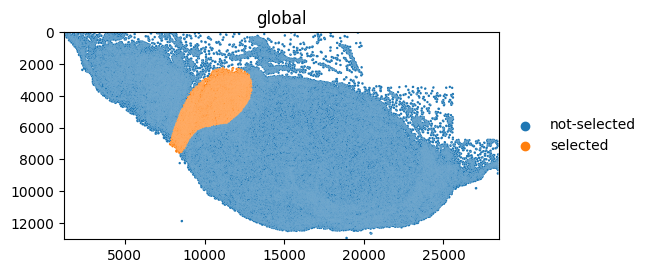

In [56]:
sdata.pl.render_shapes("cell_boundaries", color="lasso").pl.show("global")

## Cropping a `SpatialData` object from a selection

You can also export the whole selection as a polygon and use it to crop the `spatialdata` object. For that, click on "Download Selection Coordinates as CSV", as below. It will create a file called `"Selection_1_coordinates.csv"`.

<img src="assets/xenium/lasso2.png" alt="image" width="800" height="auto">

Then, we read the polygon coordinates, and perform a polygon query on the `"global"` coordinate system (i.e., the pixel coordinate system).

In [6]:
polygon = spatialdata_io.xenium_explorer_selection("Selection_1_coordinates.csv")

query_sdata = sdata.query.polygon(polygon, target_coordinate_system="global")
query_sdata

/opt/homebrew/Caskroom/miniforge/base/envs/spatialdata/lib/python3.10/site-packages/anndata/_core/anndata.py:782: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [81980, 81981, 81982, 81983, 81984]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
/opt/homebrew/Caskroom/miniforge/base/envs/spatialdata/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/spatialdata/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


SpatialData object with:
├── Images
│     ├── 'he_image': MultiscaleSpatialImage[cyx] (3, 1983, 2028), (3, 992, 1014), (3, 496, 508), (3, 248, 253), (3, 124, 127)
│     ├── 'morphology_focus': MultiscaleSpatialImage[cyx] (1, 1303, 1273), (1, 651, 637), (1, 325, 318), (1, 163, 159), (1, 81, 80)
│     └── 'morphology_mip': MultiscaleSpatialImage[cyx] (1, 1303, 1273), (1, 651, 637), (1, 325, 318), (1, 163, 159), (1, 81, 80)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 10) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (422, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (384, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (379, 1) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 384 × 382
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'reg

Using `spatialdata_plot`, we see that we indeed selected the cells we desired.

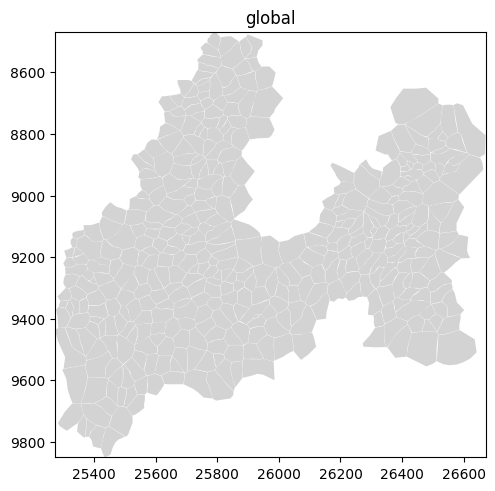

In [5]:
import spatialdata_plot

query_sdata.pl.render_shapes("cell_boundaries").pl.show()